# Road Signs classification

---

## 1. Environment Preparation

In [400]:
import  numpy as np
import pandas as pd
import tensorflow.keras as keras

random_seed = 42

In [401]:
train_data_path = "Data/archive/Train"

---

## 2. Data Loading & Augmentation

In [402]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    rotation_range=10,
    brightness_range=[0.9, 1.1],
    validation_split=0.2,
)
train = train_datagen.flow_from_directory(
    train_data_path,
    subset="training",
    seed=random_seed,
    shuffle=True,
    interpolation="bicubic",
    batch_size=64,
    target_size=(64, 64),
)
val = train_datagen.flow_from_directory(
    train_data_path,
    subset="validation",
    seed=random_seed,
    shuffle=True,
    interpolation="bicubic",
    batch_size=64,
    target_size=(64, 64),
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


The size of the train images: (64, 64, 64, 3)


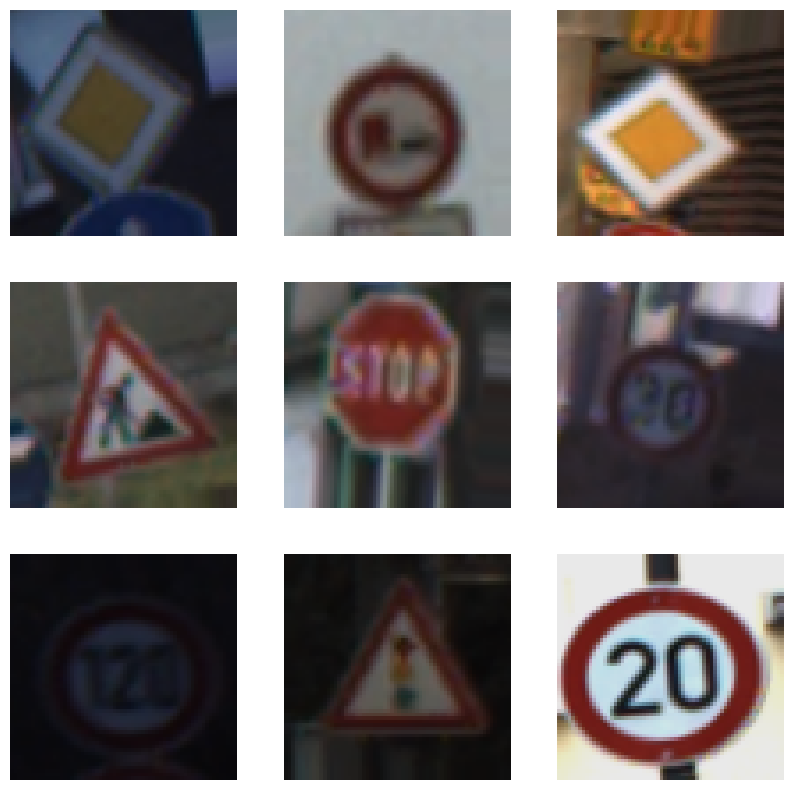

In [403]:
import matplotlib.pyplot as plt
# %% Plotting the images with the label:
train_selector = next(train)

print(f'The size of the train images: {train_selector[0].shape}')
numbers = 9 # Any perfect square number
i = 1

plt.figure(figsize=(10, 10))

for (label, image) in enumerate(train_selector[0][: numbers]):
    plt.subplot(np.sqrt(numbers).astype('int64'), np.sqrt(numbers).astype('int64'), i)
    plt.imshow(image.astype('int64'))
    plt.axis('off')
    i += 1
plt.show()

---

## 3. Model Building & Compiling

In [404]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,Rescaling,Input

# %% Building the CNN Architecture for the Prediction:

model = Sequential([
    
    Input(shape=(64, 64, 3)),
    
    Rescaling(1.0/255.0),
    
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(units=128, activation='relu'),
    Dense(units=43, activation='softmax')
])


print(model.summary())

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_21 (Rescaling)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 31, 31, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,611 (662.54 KB)

 Trainable params: 169,131 (660.67 KB)

 Non-trainable params: 480 (1.88 KB)

None


In [405]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [406]:
import tensorflow as tf

# List all physical devices (including GPUs)
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU detected.")


GPUs detected: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [407]:
earlystop = keras.callbacks.EarlyStopping(patience=4)

history = model.fit(train, validation_data=val, epochs=30,callbacks=[earlystop])

Epoch 1/30


/mnt/Files/Sorbonne_Data_Analytics_SDA/Cours/Deep_Learning_Dafnis-Krasniqi/Road_Signs_Deep_Learning_Classification/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 74s 131ms/step - accuracy: 0.6054 - loss: 1.4471 - val_accuracy: 0.6549 - val_loss: 1.1261
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 119ms/step - accuracy: 0.9647 - loss: 0.1195 - val_accuracy: 0.8856 - val_loss: 0.4136
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - accuracy: 0.9764 - loss: 0.0764 - val_accuracy: 0.9214 - val_loss: 0.3194
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 119ms/step - accuracy: 0.9867 - loss: 0.0431 - val_accuracy: 0.8975 - val_loss: 0.3674
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 121ms/step - accuracy: 0.9885 - loss: 0.0372 - val_accuracy: 0.9306 - val_loss: 0.2720
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.9890 - loss: 0.0330 - val_accuracy: 0.9330 - val_loss: 0.2750
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 61s 123ms/step - accuracy: 0.9909 - loss: 0.0267 - val_accuracy: 0.9297 - val_loss: 0.3056
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 121ms/step - accuracy: 0.9925 - loss: 0.0255 - val

Max val_acc 0.9626322984695435


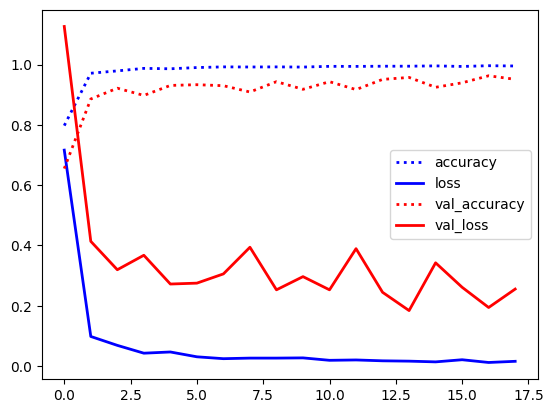

In [408]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(lw=2,style=['b:','b-','r:','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))


In [409]:
train.class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '5': 38,
 '6': 39,
 '7': 40,
 '8': 41,
 '9': 42}

---

## 4. Model Evaluation

In [410]:
test_path = "Data/archive/Test"
test_df = pd.read_csv("Data/archive/Test.csv")
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [411]:
test_df=test_df[['Path','ClassId']]
test_df['ClassId'] = test_df['ClassId'].astype(str)
test_df.head()

,Path,ClassId
0,Test/00000.png,16
1,Test/00001.png,1
2,Test/00002.png,38
3,Test/00003.png,33
4,Test/00004.png,11


In [412]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0) 
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./Data/archive/",
    x_col="Path",
    y_col="ClassId",
    batch_size=64,
    seed=42,
    shuffle=False,
    target_size=(64, 64),
)

Found 12630 validated image filenames belonging to 43 classes.


The size of the train images: (64, 64, 64, 3)


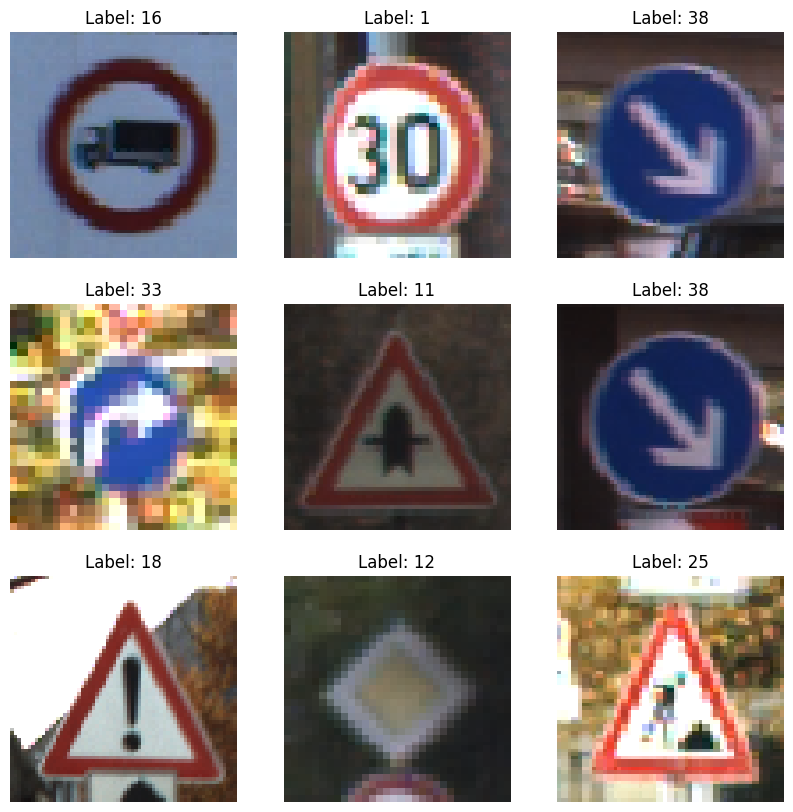

In [413]:
import matplotlib.pyplot as plt
# %% Plotting the images with the label:
train_selector = next(test_generator)

print(f'The size of the train images: {train_selector[0].shape}')
numbers = 9 # Any perfect square number
i = 1

plt.figure(figsize=(10, 10))

for (label, image) in enumerate(train_selector[0][: numbers]):
    plt.subplot(np.sqrt(numbers).astype('int64'), np.sqrt(numbers).astype('int64'), i)
    plt.title(f'Label: {labels[np.argmax(train_selector[1][label])]}')
    plt.imshow(image.astype('int64'))
    plt.axis('off')
    i += 1
plt.show()

In [414]:
test_generator.reset()
pred=model.predict(test_generator,
verbose=1)

/mnt/Files/Sorbonne_Data_Analytics_SDA/Cours/Deep_Learning_Dafnis-Krasniqi/Road_Signs_Deep_Learning_Classification/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step


In [415]:
pred.shape

(12630, 43)

In [416]:
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

array([ 8,  1, 32, ..., 37, 40,  2])

In [417]:
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [418]:
predictions

['16',
 '1',
 '38',
 '33',
 '11',
 '38',
 '18',
 '12',
 '25',
 '35',
 '12',
 '7',
 '23',
 '7',
 '4',
 '9',
 '21',
 '20',
 '27',
 '38',
 '4',
 '33',
 '9',
 '3',
 '1',
 '11',
 '13',
 '10',
 '9',
 '11',
 '5',
 '17',
 '34',
 '23',
 '2',
 '17',
 '3',
 '12',
 '16',
 '8',
 '7',
 '30',
 '18',
 '12',
 '24',
 '25',
 '3',
 '10',
 '18',
 '8',
 '25',
 '13',
 '15',
 '9',
 '13',
 '35',
 '5',
 '26',
 '9',
 '16',
 '38',
 '10',
 '4',
 '9',
 '15',
 '9',
 '26',
 '2',
 '5',
 '28',
 '11',
 '25',
 '30',
 '34',
 '5',
 '12',
 '1',
 '10',
 '25',
 '25',
 '21',
 '33',
 '25',
 '7',
 '10',
 '35',
 '3',
 '7',
 '22',
 '13',
 '3',
 '1',
 '2',
 '14',
 '12',
 '32',
 '3',
 '38',
 '9',
 '33',
 '1',
 '10',
 '5',
 '11',
 '33',
 '4',
 '35',
 '25',
 '33',
 '4',
 '1',
 '14',
 '16',
 '10',
 '30',
 '3',
 '27',
 '29',
 '1',
 '17',
 '13',
 '7',
 '1',
 '8',
 '2',
 '10',
 '10',
 '20',
 '1',
 '6',
 '36',
 '3',
 '14',
 '13',
 '11',
 '10',
 '18',
 '40',
 '2',
 '38',
 '41',
 '4',
 '6',
 '18',
 '17',
 '25',
 '2',
 '9',
 '11',
 '21',
 '7'

In [419]:
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score
print(classification_report(test_df['ClassId'], predictions))
print("Accuracy: ", accuracy_score(test_df['ClassId'], predictions))
print("Precision: ", precision_score(test_df['ClassId'], predictions, average='weighted'))
print("Recall: ", recall_score(test_df['ClassId'], predictions, average='weighted'))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        60
           1       0.97      0.99      0.98       720
          10       0.99      0.99      0.99       660
          11       0.96      0.98      0.97       420
          12       0.99      1.00      0.99       690
          13       1.00      0.99      1.00       720
          14       0.96      1.00      0.98       270
          15       1.00      1.00      1.00       210
          16       0.98      1.00      0.99       150
          17       1.00      0.96      0.98       360
          18       0.99      0.93      0.96       390
          19       1.00      1.00      1.00        60
           2       0.99      0.95      0.97       750
          20       0.87      1.00      0.93        90
          21       0.95      1.00      0.97        90
          22       1.00      0.81      0.89       120
          23       0.99      1.00      1.00       150
          24       0.99    

In [420]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_df['ClassId'], predictions)

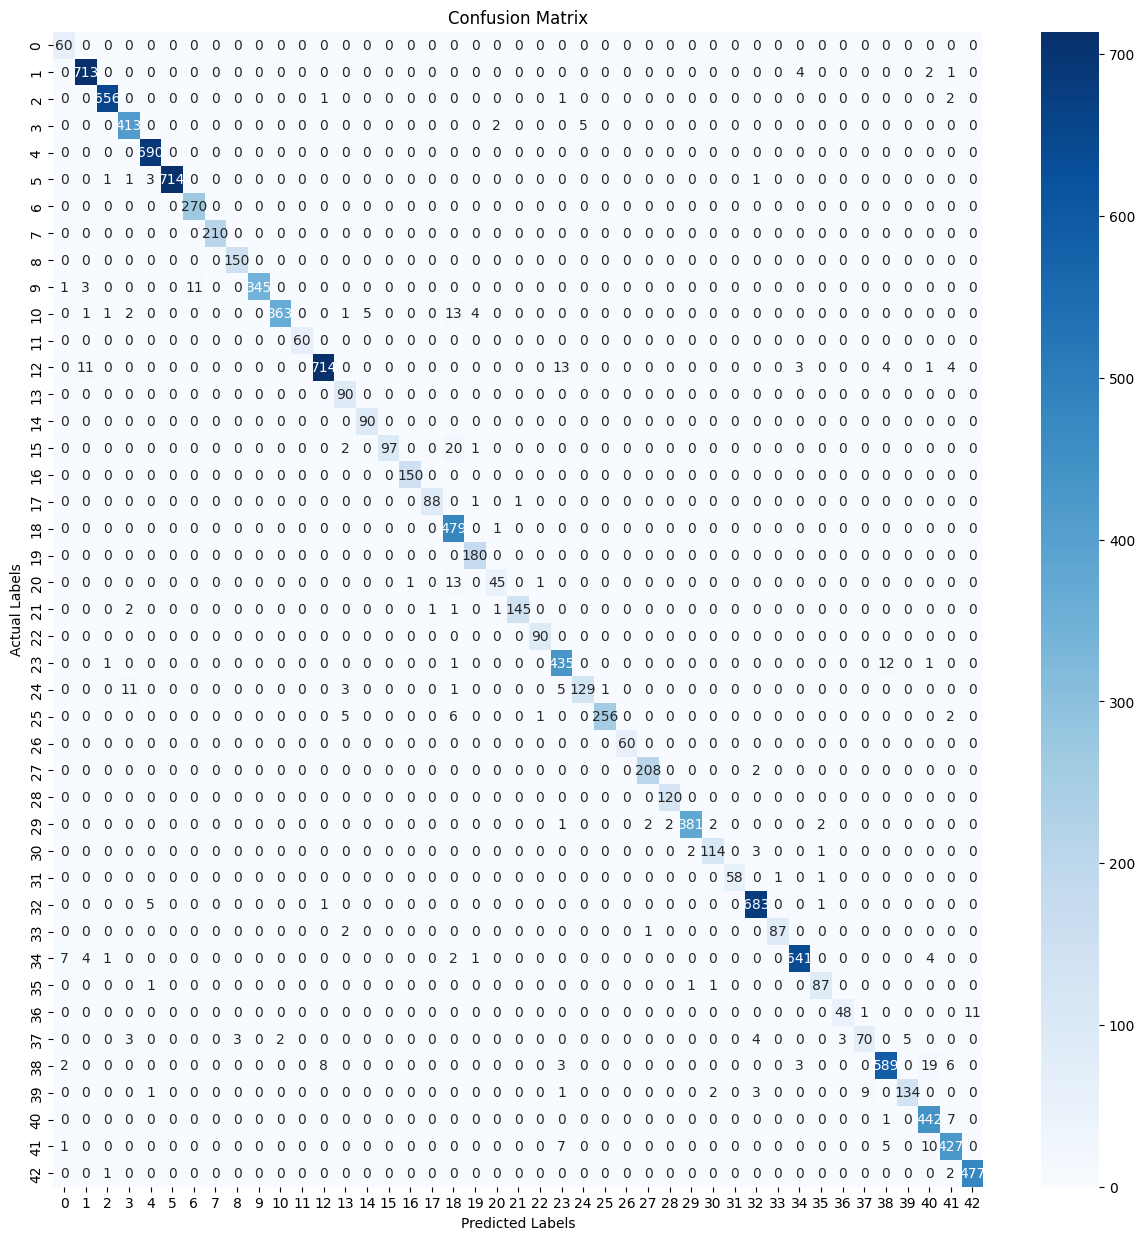

In [421]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()